In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import namedtuple, deque
from IPython import display
# pip install git+https://github.com/jakevdp/JSAnimation.git
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
%load_ext autoreload
%autoreload
run = 0

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Actions: 2
Raw observation space: (4,)
Max episode steps: 200
((4,), 1.0)
count    4.000000
mean    -0.029260
std      0.196272
min     -0.309835
25%     -0.068279
50%      0.022657
75%      0.061675
max      0.147482
dtype: float64


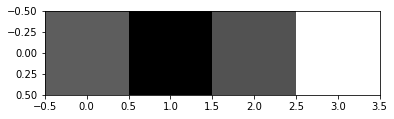

In [330]:
# env = PongV0Wrapper(gym.make('Pong-v0'))
env = gym.make('CartPole-v0')
    
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))

def test(env):
    state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    print(state.shape, reward)
    print(pd.Series(state.flatten()).describe())
    plt.imshow(state.reshape((1, 4)), cmap='Greys')

test(env)

In [324]:
class LearningParameters:
    def __init__(self, env, state, episodes_count):
        self.state_shape = state.shape
        self.state_size = np.prod(self.state_shape)
        self.action_size = env.action_space.n
        self.episodes_count = episodes_count
        self.max_frame_in_episode = env.spec.max_episode_steps
        self.max_memory_size = 10000
        self.episodes_between_think = 1
        self.episodes_warmup = 5

        self.gamma = 0.95                # rewards discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.05          # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model

def decay_exploration_rate(params, episode):
    # Exponential rate decay
    # y(0) = start
    # y(1) = start * x
    # y(2) = start * x^2
    # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
    # y(t) = start * x^t
    x = math.pow(params.epsilon_min / params.epsilon_start, 1.0 / params.episodes_count)
    params.epsilon = params.epsilon_start * math.pow(x, episode)
        
def train(session, tfwriter, env, agent, params):
    agent.session = session
    agent.tfwriter = tfwriter
    
    rewards = []

    for episode in range(params.episodes_count):
        state = env.reset()

        replays = []

        for frame in range(params.max_frame_in_episode):
            action = agent.act(state, frame)

            next_state, reward, done, _ = env.step(action)

            if done:
                reward = -1
            
            replays.append((frame, state, action, reward, next_state))

            if done:
                break
                
            state = next_state

        episode_rewards = list(r[3] for r in replays)
        rewards.append(sum(episode_rewards))
        
        for i in range(len(replays)):
            frame, state, action, _, next_state = replays[i]
            agent.remember(state, action, episode_rewards[i], next_state, frame)

        if episode > params.episodes_warmup and (episode + 1) % params.episodes_between_think == 0:
            agent.think(params.batch_size, episode)

        decay_exploration_rate(params, episode)
        
        tfwriter.add_summary(tf.Summary(value=[
            tf.Summary.Value(tag='Train/Reward_sum', simple_value=rewards[-1]),
        ]), episode)

    return agent, rewards

In [325]:
class FlatMemory:
    def __init__(self, max_memory_size, state_size):
        self.states      = np.zeros((2 * max_memory_size, state_size))
        self.next_states = np.zeros((2 * max_memory_size, state_size))
        self.actions     = np.zeros((2 * max_memory_size), dtype=np.int32)
        self.rewards     = np.zeros((2 * max_memory_size))
        self.index = 0
        self.inner_cnt = 0
        self.cnt = 0
        self.max_memory_size = max_memory_size
    
    def remember(self, state, action, reward, next_state, frame):
        self.states[self.inner_cnt] = state
        self.next_states[self.inner_cnt] = next_state
        self.actions[self.inner_cnt] = action
        self.rewards[self.inner_cnt] = reward
        self.inner_cnt += 1

        n = self.max_memory_size
        
        if self.cnt < n:
            self.cnt += 1
        else:
            self.index += 1
        
        if self.inner_cnt == 2 * n:
            self.states[:n] = self.states[-n:]
            self.next_states[:n] = self.next_states[-n:]
            self.actions[:n] = self.actions[-n:]
            self.rewards[:n] = self.rewards[-n:]
            self.index = 0
            self.inner_cnt = n
        
    def get_states(self):
        return self.states[self.index : self.index + self.cnt, :]
    
    def get_next_states(self):
        return self.next_states[self.index : self.index + self.cnt, :]
        
    def get_actions(self):
        return self.actions[self.index : self.index + self.cnt]
    
    def get_rewards(self):
        return self.rewards[self.index : self.index + self.cnt]

In [326]:
def _split_seq_to_rnn_batches(seq, B, rnn_steps):
    """
    Returns an iterator, every item is a numpy array with shape:
    (B, rnn_steps) + seq.shape[1:]
    Array is filled with seq sub sequences prepared for RNN.
    Every row in array is a continuation of a previous array (RNN state can be reused)
    """
    cnt = seq.shape[0]
    
    out_shape = (B, rnn_steps) + seq.shape[1:]
    
    if len(seq.shape) == 1:
        seq = seq.reshape((seq.shape[0], 1))
    
    roll = np.repeat(np.arange(B).reshape((B, 1)), rnn_steps, axis=1) + np.arange(rnn_steps)
    
    # roll here:
    # 0 1 2 ... rnn_steps
    # 1 2 3 ... rnn_steps+1
    # 2 3 4 ... rnn_steps+2
    #       ...
    # B-1   ... rnn_steps+B-2

    # reshape to 1-D
    roll = roll.reshape((B * rnn_steps,))
    
    for first in range(0, cnt - ( rnn_steps + B - 2 ), rnn_steps):
        result = seq[roll + first, :].reshape(out_shape)
    
        yield result
    
# for batch in _split_seq_to_rnn_batches(np.arange(19), B=2, rnn_steps=3):
for batch in _split_seq_to_rnn_batches(np.arange(21).reshape((7, 3)), B=2, rnn_steps=3):
    print(batch)
    print('---')

[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 3  4  5]
  [ 6  7  8]
  [ 9 10 11]]]
---
[[[ 9 10 11]
  [12 13 14]
  [15 16 17]]

 [[12 13 14]
  [15 16 17]
  [18 19 20]]]
---


In [327]:
def _normalize(a):
    a -= np.mean(a)
    std = np.std(a)
    if std != 0:
        a /= std
    return a

In [247]:
class RnnModel:
    def __init__(self, params):
        self.params = params
        self.memory = FlatMemory(params.max_memory_size, params.state_size)
        self._build_rnn_model()
    
        self.current_rnn_state = None
        self.current_rnn_state_counter = 0
    
    def _build_rnn_model(self):
        S = self.params.state_size
        A = self.params.action_size
        
        self.rnn_s  = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_s")
        self.rnn_ns = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_ns")
        self.rnn_a  = tf.placeholder("int32", [None, None], name="Placeholder_rnn_a")
        
        action_ohe = tf.one_hot(self.rnn_a, depth=A)
        state_and_action = tf.concat([self.rnn_s, action_ohe], axis=2)

        self.rnn_cell = tf.contrib.rnn.LSTMCell(
            self.params.rnn_state_size,
            num_proj=S,
            initializer=tf.random_uniform_initializer(-1, 1))

        self.rnn_is = self.rnn_cell.zero_state(tf.shape(self.rnn_s)[0], tf.float32)
        
        self.predictions, self.rnn_final_state = \
            tf.nn.dynamic_rnn(self.rnn_cell, state_and_action,
               initial_state=self.rnn_is,
               dtype=tf.float32)

        self.rnn_cost = tf.reduce_mean(tf.squared_difference(self.predictions, self.rnn_ns))

        self.rnn_train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.rnn_cost)
        
    def remember(self, state, action, reward, next_state, frame):
        S = self.params.state_size
        
        if (self.current_rnn_state_counter % self.params.reset_rnn_state_iters == 0):
            self.current_rnn_state = (np.zeros((1, self.params.rnn_state_size)), np.zeros((1, S)))
        self.current_rnn_state_counter += 1
        
        pred, self.current_rnn_state = self.session.run(
            [self.predictions, self.rnn_final_state],
            feed_dict = {
                self.rnn_s: state.reshape((1, 1, S)),
                self.rnn_a: np.array([action]).reshape((1, 1)),
                self.rnn_is: self.current_rnn_state
            })

        pred_err = np.mean(np.square(pred - next_state))
        
        self.tfwriter.add_summary(tf.Summary(value=[
                tf.Summary.Value(tag='Train_RNN/Actual_pred_mse', simple_value=pred_err),
            ]), self.current_rnn_state_counter)

        self.memory.remember(state, action, reward, next_state, frame)

    def act(self, state, frame):
        return np.random.randint(0, self.params.action_size)
    
    def _get_rnn_batches(self):
        states = self.memory.get_states()
        next_states = self.memory.get_next_states()
        actions = self.memory.get_actions()

        B = self.params.batch_size
        RS = self.params.rnn_steps
        
        iter_state = _split_seq_to_rnn_batches(states, B, RS)
        iter_next_states = _split_seq_to_rnn_batches(next_states, B, RS)
        iter_actions = _split_seq_to_rnn_batches(actions, B, RS)
        
        while True:
            rnn_state = next(iter_state, None)
            rnn_next_state = next(iter_next_states, None)
            rnn_actions = next(iter_actions, None)
            
            if (rnn_state is None or rnn_next_state is None or rnn_actions is None):
                break
                
            yield (rnn_state, rnn_next_state, rnn_actions)
        
    def think(self, batch_size, episode):
        if self.memory.cnt < self.params.batch_size + self.params.rnn_steps:
            return
        
        session = self.session
        B = self.params.batch_size
        S = self.params.state_size
        A = self.params.action_size
        
        costs = []
        
        RNN_State = (np.zeros((B, self.params.rnn_state_size)), np.zeros((B, S)))
        
        for RNN_S, RNN_NS, RNN_A in self._get_rnn_batches():
            cost, RNN_State, _ = \
                session.run([self.rnn_cost, self.rnn_final_state, self.rnn_train_op],
                          feed_dict={self.rnn_s: RNN_S,
                                     self.rnn_ns: RNN_NS,
                                     self.rnn_a: RNN_A,
                                     self.rnn_is: RNN_State})
            costs.append(cost)
        
        rewards = self.memory.get_rewards()
        self.tfwriter.add_summary(tf.Summary(value=[
                tf.Summary.Value(tag='Train_RNN/Steps', simple_value=len(costs)),
                tf.Summary.Value(tag='Train_RNN/Cost_mean', simple_value=np.mean(costs)),
                tf.Summary.Value(tag='DataStats/Rewards_min', simple_value=np.min(rewards)),
                tf.Summary.Value(tag='DataStats/Rewards_max', simple_value=np.max(rewards)),
            ]), episode)

In [328]:
class RnnQModel:
    def __init__(self, params):
        self.params = params
        self.memory = FlatMemory(params.max_memory_size, params.state_size)
        self._build_rnn_model()
    
        self._reset_rnn_state()
        self.current_rnn_state_counter = 0
    
    def _build_rnn_model(self):
        S = self.params.state_size
        A = self.params.action_size
        
        self.rnn_s  = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_s")
        self.rnn_ns = tf.placeholder("float", [None, None, S], name="Placeholder_rnn_ns")
        self.rnn_a  = tf.placeholder("int32", [None, None], name="Placeholder_rnn_a")
        self.qv     = tf.placeholder("float", [None, None], name="Placeholder_rnn_qv")
        
        action_ohe = tf.one_hot(self.rnn_a, depth=A)
        state_and_action = tf.concat([self.rnn_s, action_ohe], axis=2)

        self.rnn_cell = tf.contrib.rnn.LSTMCell(
            self.params.rnn_state_size,
            num_proj=S + 1,
            initializer=tf.random_uniform_initializer(-1, 1))

        self.rnn_is = self.rnn_cell.zero_state(tf.shape(self.rnn_s)[0], tf.float32)
        
        predictions, self.rnn_final_state = \
            tf.nn.dynamic_rnn(self.rnn_cell, state_and_action,
               initial_state=self.rnn_is,
               dtype=tf.float32)
        print('predictions', predictions)
        print('self.rnn_final_state', self.rnn_final_state)
            
        self.rnn_state_pred, qv_pred = tf.split(predictions, [S, 1], axis=2)
        self.qv_pred = tf.reshape(qv_pred, (tf.shape(qv_pred)[0], tf.shape(qv_pred)[1]))
        print('self.rnn_state_pred', self.rnn_state_pred)
        print('self.qv_pred', self.qv_pred)

        rnn_state_cost = tf.reduce_mean(tf.squared_difference(self.rnn_state_pred, self.rnn_ns))
        
        rnn_qv_cost = tf.reduce_mean(tf.squared_difference(self.qv_pred, self.qv))

        self.rnn_cost = rnn_state_cost + rnn_qv_cost
        
        self.rnn_train_op = tf.train.GradientDescentOptimizer(learning_rate=self.params.learning_rate) \
            .minimize(self.rnn_cost)
        
    def remember(self, state, action, reward, next_state, frame):
        self.memory.remember(state, action, reward, next_state, frame)

    def _reset_rnn_state(self):
        S = self.params.state_size
        self.current_rnn_state = (np.zeros((1, self.params.rnn_state_size)), np.zeros((1, S + 1)))
        
    def act(self, state, frame):
        S = self.params.state_size
            
        # TODO: Get rnn_steps states/actions instead of resetting
        if self.memory.cnt > 0:
            pred, self.current_rnn_state = self.session.run(
                [self.rnn_state_pred, self.rnn_final_state],
                feed_dict = {
                    self.rnn_s: self.prev_state.reshape((1, 1, S)),
                    self.rnn_a: np.array([self.prev_action]).reshape((1, 1)),
                    self.rnn_is: self.current_rnn_state
                })

            pred_err = np.mean(np.square(pred - state))

            self.tfwriter.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag='Train_RNN/Actual_pred_mse', simple_value=pred_err),
                ]), self.current_rnn_state_counter)
        
        action = np.random.randint(0, self.params.action_size) if np.random.rand() <= self.params.epsilon \
            else self.act_greedy(state, frame)
#         action = np.random.randint(0, self.params.action_size)
        
        self.prev_state = state
        self.prev_action = action

        if (self.current_rnn_state_counter % self.params.reset_rnn_state_iters == 0):
            self._reset_rnn_state()
        self.current_rnn_state_counter += 1
        
        return action

    def act_greedy(self, state, frame):
        A = self.params.action_size
        S = self.params.state_size
        
        lstm_h, lstm_c = self.current_rnn_state

        lstm_h = np.repeat(lstm_h.reshape((1, 1, self.params.rnn_state_size)), A, axis=0)
        lstm_c = np.repeat(lstm_c.reshape((1, 1, S + 1)), A, axis=0)
        
        rnns = np.repeat(state.reshape((1, 1, S)), A, axis=0)
        rnna = np.arange(A).reshape((A, 1))
        
        pred_qv = self.session.run(
            self.qv_pred,
            feed_dict={
                self.rnn_s: rnns,
                self.rnn_a: rnna
            })
        
        return np.argmax(pred_qv.reshape(A))
        
    def _get_rnn_batches(self, *items):
        B = self.params.batch_size
        RS = self.params.rnn_steps
        
        iterators = [_split_seq_to_rnn_batches(item, B, RS) for item in items]
        
        while True:
            rnn_items = [next(iterator, None) for iterator in iterators]

            if any(i is None for i in rnn_items):
                break

            yield rnn_items
        
    def think(self, batch_size, episode):
        if self.memory.cnt < self.params.batch_size + self.params.rnn_steps:
            return
        
        session = self.session
        B = self.params.batch_size
        S = self.params.state_size
        A = self.params.action_size
        
        costs = []
        
        # TODO: Calc initial state better
        cnt = self.memory.cnt
        a0 = np.zeros((cnt, 1), dtype='int32')
        a1 = np.ones((cnt, 1), dtype='int32')
        ns = self.memory.get_next_states().reshape((cnt, 1, S))
        init = (np.zeros((cnt, self.params.rnn_state_size)), np.zeros((cnt, S + 1)))
        nextValues = np.zeros((cnt, A))
        nextValues[:,0] = session.run(self.qv_pred, {self.rnn_s: ns, self.rnn_a: a0, self.rnn_is: init})[:,0]
        nextValues[:,1] = session.run(self.qv_pred, {self.rnn_s: ns, self.rnn_a: a1, self.rnn_is: init})[:,0]
        y = self.memory.get_rewards() + self.params.gamma * np.amax(nextValues, axis=1)
        y = _normalize(y)
        
        RNN_State = (np.zeros((B, self.params.rnn_state_size)), np.zeros((B, S + 1)))
        
        batch_iterator = self._get_rnn_batches(
            self.memory.get_states(),
            self.memory.get_next_states(),
            self.memory.get_actions(),
            y)
        
        for RNN_S, RNN_NS, RNN_A, RNN_Q in batch_iterator:
            
            cost, RNN_State, _ = \
                session.run([self.rnn_cost, self.rnn_final_state, self.rnn_train_op],
                          feed_dict={self.rnn_s: RNN_S,
                                     self.rnn_ns: RNN_NS,
                                     self.rnn_a: RNN_A,
                                     self.rnn_is: RNN_State,
                                     self.qv: RNN_Q})
            costs.append(cost)
        
        rewards = self.memory.get_rewards()
        self.tfwriter.add_summary(tf.Summary(value=[
                tf.Summary.Value(tag='Train_RNN/Steps', simple_value=len(costs)),
                tf.Summary.Value(tag='Train_RNN/Cost_mean', simple_value=np.mean(costs)),
                tf.Summary.Value(tag='DataStats/Rewards_min', simple_value=np.min(rewards)),
                tf.Summary.Value(tag='DataStats/Rewards_max', simple_value=np.max(rewards)),
            ]), episode)

('predictions', <tf.Tensor 'rnn/transpose_1:0' shape=(?, ?, 5) dtype=float32>)
('self.rnn_final_state', LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 3) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 5) dtype=float32>))
('self.rnn_state_pred', <tf.Tensor 'split:0' shape=(?, ?, 4) dtype=float32>)
('self.qv_pred', <tf.Tensor 'Reshape:0' shape=(?, ?) dtype=float32>)
CPU times: user 4min 57s, sys: 1min 1s, total: 5min 58s
Wall time: 3min 5s


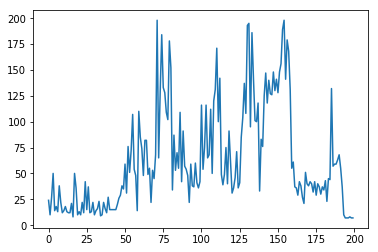

In [331]:
%%time
run += 1
tf.reset_default_graph()

params = LearningParameters(env, env.reset(), episodes_count=200)
params.max_frame_in_episode = min(params.max_frame_in_episode, 500)
params.learning_rate = 0.003
params.max_memory_size = 1000
params.reset_rnn_state_iters = 10
params.batch_size = 32
params.rnn_state_size = 3
params.rnn_steps = 4
agent = RnnQModel(params)

# Train on GPU
config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction=0.7
# config.operation_timeout_in_ms=60000

# Train on CPU
# config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    tfwriter = tf.summary.FileWriter('logs/run' + str(run), session.graph)
    
    session.run(tf.global_variables_initializer())

    agent, rewards = train(session, tfwriter, env, agent, params)

    tfwriter.close()
    
    plt.plot(rewards)